# [SLATS の地図タイル画像を時系列で連続表示する](https://www.tellusxdp.com/ja/howtouse/dev/20200221_000258.html)

In [1]:
import os
import json

fpth_secret = os.path.join(os.environ['HOME'], 'working/jupyter/secret.json')
with open(fpth_secret) as f:
    secret = json.load(f)
TOKEN = secret['tellus']
HEADERS = {
    'Authorization': 'Bearer ' + TOKEN
}

In [2]:
import requests

def fetch_tsubame_scenes(lat_lon):
    url = 'https://gisapi.tellusxdp.com'
    url += '/api/v1/tsubame/scene'
    
    r = requests.get(url, params=lat_lon, headers=HEADERS)
    return r.json()

lat_lon = {
    'min_lat': 20.425278,
    'min_lon': 122.933611,
    'max_lat': 45.557222,
    'max_lon': 153.986389
}
scenes = fetch_tsubame_scenes(lat_lon)
print(len(scenes))

83


In [3]:
import dateutil.parser
from datetime import datetime
from datetime import timezone

def filter_scenes_by_date(scenes, begin_date=None, end_date=None):
    if begin_date is None:
        start_date = datetime(1900, 1, 1, tzinfo=timezone.utc)
    if end_date is None:
        start_date = datetime.now(timezone.utc)
        
    extract_scenes = []
    for scene in scenes:
        scene_date = dateutil.parser.parse(scene['acquisitionDate'])
        if begin_date <= scene_date and scene_date < end_date:
            extract_scenes.append(scene)
    return extract_scenes

extract_scenes = filter_scenes_by_date(
    scenes,
    datetime(2019, 4, 10, tzinfo=timezone.utc),
    datetime(2019, 5, 11, tzinfo=timezone.utc)
)
print(len(extract_scenes))

23


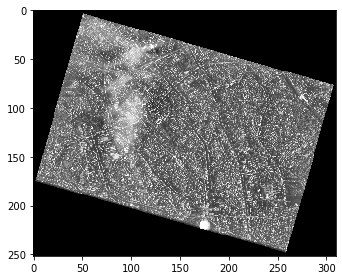

In [4]:
from skimage import io
io.imshow(io.imread(extract_scenes[-1]['thumbs_url']))

In [5]:
import numpy as np

def filter_scenes_by_area(scenes, areas):
    results = [[] for _ in areas]
    for scene in scenes:
        scene_pos = np.array([scene['clat'], scene['clon']])
        distance = []
        for area in areas:
            area_pos = np.array([area['lat'], area['lon']])
            distance.append(np.linalg.norm(scene_pos - area_pos))
        results[np.argmin(distance)].append(scene)
    return results


observation_areas = [
    {
        'name': '赤坂迎賓館',
        'lat': 35.68031,
        'lon': 139.729216
    },
    {
        'name': '小石川',
        'lat': 35.719582,
        'lon': 139.744686
    }
]
akasaka_scenes, koishigawa_scenes = filter_scenes_by_area(extract_scenes, observation_areas)
print(len(akasaka_scenes))
print(len(koishigawa_scenes))

12
11


In [6]:
akasaka_scenes = akasaka_scenes[::-1]
for s in akasaka_scenes:
    print(s['acquisitionDate'])

Sat, 13 Apr 2019 07:29:49 GMT
Mon, 15 Apr 2019 07:31:50 GMT
Tue, 16 Apr 2019 07:32:51 GMT
Sat, 20 Apr 2019 07:36:53 GMT
Sun, 21 Apr 2019 07:37:52 GMT
Mon, 22 Apr 2019 07:38:53 GMT
Tue, 23 Apr 2019 07:39:53 GMT
Thu, 25 Apr 2019 07:41:54 GMT
Thu, 02 May 2019 07:48:56 GMT
Sun, 05 May 2019 07:51:57 GMT
Wed, 08 May 2019 07:54:58 GMT
Fri, 10 May 2019 07:56:58 GMT


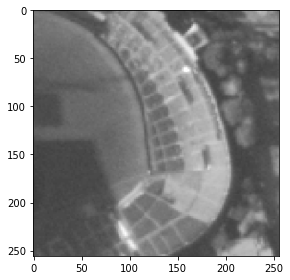

In [7]:
from io import BytesIO

def fetch_tsubame_image(sceneid, tile):
    params = {'scene_id': sceneid}
    params.update(tile)
    url = 'https://gisapi.tellusxdp.com'
    url += '/tsubame/{scene_id}/{z}/{x}/{y}.png'.format(**params)
    
    r = requests.get(url, headers=HEADERS)
    return io.imread(BytesIO(r.content))

tile = {
    'x': 232811,
    'y': 103230,
    'z': 18
}
img = fetch_tsubame_image(akasaka_scenes[0]['entityId'], tile)
io.imshow(img)

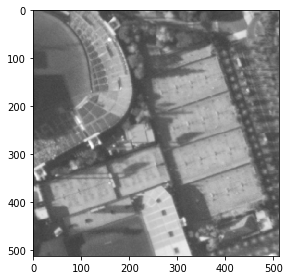

In [8]:
def fetch_tsubame_images(sceneid, tile, size):
    col_img = []
    for x in range(size[0]):
        img = []
        for y in range(size[1]):
            tile_temp = tile.copy()
            tile_temp['x'] += x
            tile_temp['y'] += y
            img.append(fetch_tsubame_image(sceneid, tile_temp))
        col_img.append(np.vstack(img))
    return np.hstack(col_img)

img = fetch_tsubame_images(akasaka_scenes[0]['entityId'], tile, (2, 2))
io.imshow(img)

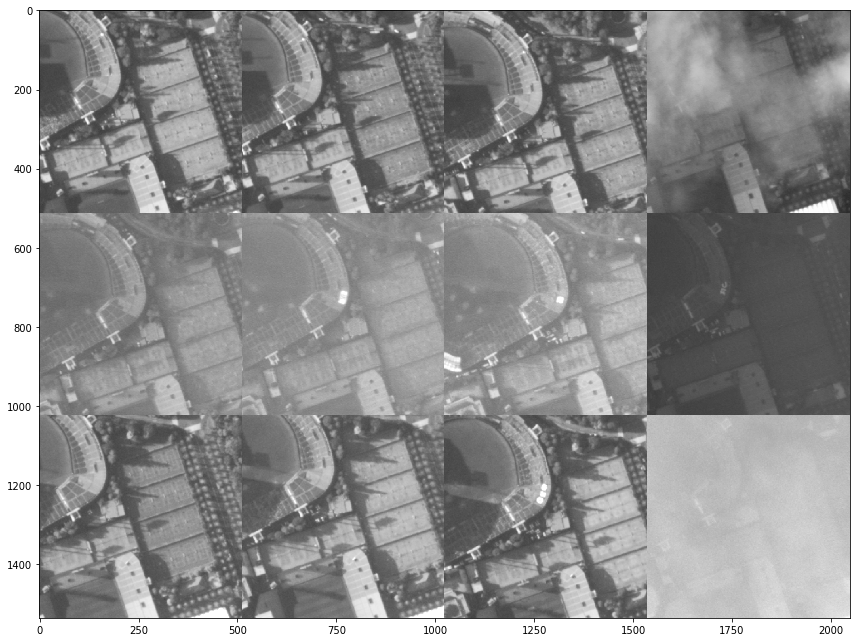

In [9]:
import math

import matplotlib.pyplot as plt

def generate_grid_image(scenes, tile, size, col_size):
    images = [fetch_tsubame_images(s['entityId'], tile, size) for s in scenes] 
    
    row_img = []
    count = 0
    for row in range(math.ceil(len(scenes) / col_size)):
        img = []
        for col in range(col_size):
            if count < len(scenes):
                img.append(images[count])
                count += 1
            else:
                img.append(np.ones_like(images[0]) * 255)
        row_img.append(np.hstack(img))
    return np.vstack(row_img)
 
img = generate_grid_image(akasaka_scenes, tile, (2, 2), 4)

plt.rcParams['figure.figsize'] = (12, 12)
io.imshow(img)